# Time series with external regressors

In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
import tensorflow.keras.models as tkm
import tensorflow.keras.layers as tkl

## Helpers

#### Stationarization

In [114]:
def diff(ts, span=1):
    return pd.Series([(ts[i] - ts[i-span]) for i in range(span, len(ts))])
    
def inv_diff(hist, pred, span=1):
    return pred + hist[-span]

#### Scaling

In [130]:
def scale(train, test):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    
    train = train.reshape(train.shape[0], train.shape[1])
    train_sc = scaler.transform(train)
    
    test = test.reshape(test.shape[0], test.shape[1])
    test_sc = scaler.transform(test)
    return scaler, train_sc, test_sc

def inv_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inv_array = scaler.inverse_transform(array)
    return inv_array[0, -1]

#### Build dataset from ts

In [ ]:
def build_ds(ts, lag=1):
    df = pd.DataFrame(ts)
    cols = [df.shift(t) for t in range(1, lag+1)]
    cols.append(df)
    df = pd.concat(cols, axis=1)
    df.fillna(0, inplace=True)
    return df

#### Univariate forecast one step

In [ ]:
def build_model_uo(ds_train, batch_size, eps, neurons, verbose=True):
    X, y = ds_train[:, 0:-1], ds_train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = tkm.Sequential()
    model.add(tfl.LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(tfl.Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(eps):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=verbose, shuffle=False)
        model.reset_states()
    return model

def fcst_uo(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    pred = model.predict(X, batch_size=batch_size)
    return pred[0,0]

#### Univariate forecast n steps

In [ ]:
def build_ds_un(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

#### Multivariate forecast

In [ ]:
def build_ds_mo(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

## Load data

In [93]:
df = pd.read_csv('D:/data/csv/bike_sharing_day.csv')
df = df[['dteday', 'atemp', 'weathersit', 'cnt']].dropna()

df['date'] = pd.to_datetime(df['dteday'])
df = df.set_index('date')

df = df.resample('D').mean()
df = df.reset_index().dropna()
df.columns = ['date', 'temp', 'weather', 'cnt']
df.head()

,date,temp,weather,cnt
0,2011-01-01,0.363625,2,985
1,2011-01-02,0.353739,2,801
2,2011-01-03,0.189405,1,1349
3,2011-01-04,0.212122,1,1562
4,2011-01-05,0.229270,1,1600


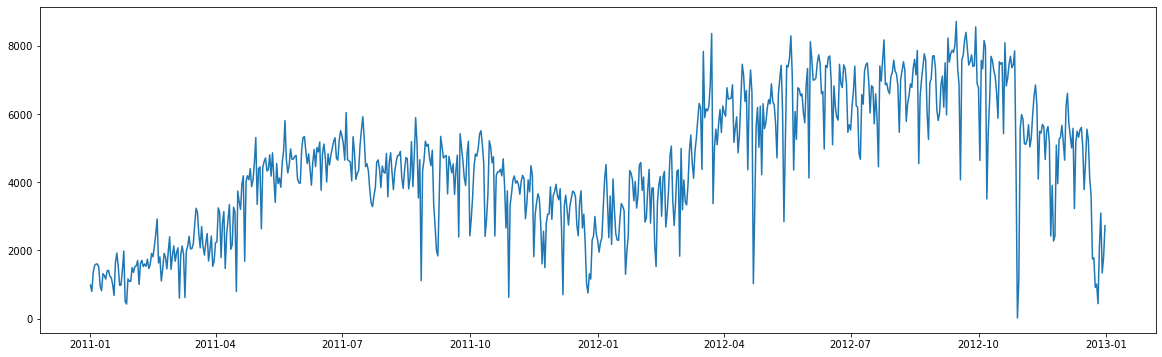

In [82]:
fig = plt.figure(facecolor='w', figsize=(20, 6))
plt.plot(df.date, df.cnt);

## One step univariate forecast

#### Forecast

In [122]:
# differentiation
ts = df['cnt'].values
ts_diff = diff(ts, 1)
ts_diff[0:10]

0   -184
1    548
2    213
3     38
4      6
5    -96
6   -551
7   -137
8    499
9    -58
dtype: int64

In [128]:
# build dataset
ds = build_ds(ts_diff, 1).values
ds[0:10]

array([[   0., -184.],
       [-184.,  548.],
       [ 548.,  213.],
       [ 213.,   38.],
       [  38.,    6.],
       [   6.,  -96.],
       [ -96., -551.],
       [-551., -137.],
       [-137.,  499.],
       [ 499.,  -58.]])

In [131]:
# split train/test
ds_train, ds_test = ds[0:-12], ds[-12:]
 
# scaling
scaler, ds_train_sc, ds_test_sc = scale(ds_train, ds_test)
ds_train_sc

array([[ 0.11194994,  0.07539485],
       [ 0.07539485,  0.2208205 ],
       [ 0.2208205 ,  0.15426642],
       ...,
       [-0.13857157,  0.2706864 ],
       [ 0.2706864 ,  0.30505612],
       [ 0.30505612,  0.05433595]])

In [132]:
# fit the model
lstm = build_model_uo(ds_train_sc, batch_size=1, nb_epoch=500, neurons=4, verbose=True)

# forecast the entire training dataset to build up state for forecasting
ds_train_inp = ds_train_sc[:, 0].reshape(len(ds_train_sc), 1, 1)
lstm.predict(ds_train_inp, batch_size=1)

718/718 [==============================] - 1s 945us/step - loss: 0.0328


array([[ 1.24988943e-01],
       [ 1.12196974e-01],
       [ 7.14562759e-02],
       [ 5.66490591e-02],
       [ 5.27564809e-02],
       [ 5.22844046e-02],
       [ 5.78722954e-02],
       [ 9.64852050e-02],
       [ 9.79972780e-02],
       [ 7.32959136e-02],
       [ 7.47833848e-02],
       [ 7.79009536e-02],
       [ 6.62562922e-02],
       [ 6.61785752e-02],
       [ 7.57103637e-02],
       [ 7.71038979e-02],
       [ 8.87603909e-02],
       [ 1.07819177e-01],
       [ 6.79548383e-02],
       [ 5.13380915e-02],
       [ 7.08620399e-02],
       [ 1.06359847e-01],
       [ 9.48828012e-02],
       [ 7.19066635e-02],
       [ 5.09299189e-02],
       [ 2.26932168e-01],
       [ 1.76823303e-01],
       [ 1.00986212e-01],
       [ 9.34910700e-02],
       [ 8.55517462e-02],
       [ 6.56940863e-02],
       [ 7.24307895e-02],
       [ 6.30904585e-02],
       [ 6.25296757e-02],
       [ 5.68053648e-02],
       [ 1.11903518e-01],
       [ 7.26991817e-02],
       [ 6.40938580e-02],
       [ 7.1

#### Validation

Month	Predicted	Expected
1 	 5023.613 	 4128
2 	 4434.293 	 3623
3 	 4017.878 	 1749
4 	 3614.233 	 1787
5 	 2852.031 	 920
6 	 2398.095 	 1013
7 	 1884.903 	 441
8 	 1475.343 	 2114
9 	 2161.738 	 3095
10 	 2826.410 	 1341
11 	 2230.625 	 1796
12 	 2018.447 	 2729

Test RMSE: 1349.755


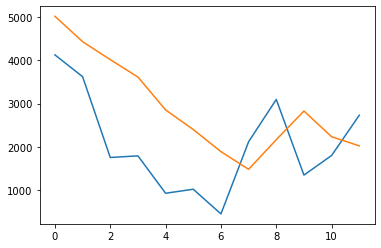

In [136]:
pred = list()
print('Month\tPredicted\tExpected')
for i in range(len(ds_test_sc)):
    X, y = ds_test_sc[i, 0:-1], ds_test_sc[i, -1]
    fcst_diff_sc = fcst_uo(lstm, 1, X)
    fcst_diff = inv_scale(scaler, X, fcst_diff_sc)
    fcst = inv_diff(ts, fcst_diff, len(ds_test_sc)+1-i)
    pred.append(fcst)
    hist = ts[len(ds_train) + i + 1]
    print(i+1, '\t', '{:.3f}'.format(fcst), '\t', hist)
 
rmse = sqrt(mean_squared_error(ts[-12:], pred))
print('\nTest RMSE:', '{0:.3f}'.format(rmse))

plt.plot(ts[-12:])
plt.plot(pred)
plt.show()

## N steps univariate forecast

## Multivariate forecast

In [94]:
# split train/test
ds_train, ds_test = ds[0:-12], ds[-12:]

scaler, ds_train_sc, ds_test_sc = scale(ds_train, ds_test)

In [95]:
train_X, train_y = ds_train_sc[:, :-1], ds_train_sc[:, -1]
test_X, test_y = ds_test_sc[:, :-1], ds_test_sc[:, -1]

In [96]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(718, 1, 1) (718,) (12, 1, 1) (12,)


In [99]:
train_X

array([[[ 1.11949935e-01]],

       [[ 7.53948545e-02]],

       [[ 2.20820503e-01]],

       [[ 1.54266415e-01]],

       [[ 1.19499354e-01]],

       [[ 1.13141949e-01]],

       [[ 9.28777193e-02]],

       [[ 2.48336148e-03]],

       [[ 8.47322936e-02]],

       [[ 2.11085726e-01]],

       [[ 1.00427138e-01]],

       [[ 9.18843747e-02]],

       [[ 1.60425151e-01]],

       [[ 1.14929969e-01]],

       [[ 7.75802126e-02]],

       [[ 1.03208503e-01]],

       [[ 7.14214761e-02]],

       [[ 4.89718883e-02]],

       [[ 3.04062779e-01]],

       [[ 1.66981226e-01]],

       [[ 3.56610708e-02]],

       [[ 2.98003377e-04]],

       [[ 1.12943280e-01]],

       [[ 1.97377570e-01]],

       [[ 2.24992550e-01]],

       [[-1.81881395e-01]],

       [[ 9.70497666e-02]],

       [[ 2.58170259e-01]],

       [[ 9.82417801e-02]],

       [[ 1.11552598e-01]],

       [[ 1.92410847e-01]],

       [[ 8.39376180e-02]],

       [[ 1.44928976e-01]],

       [[ 1.16717989e-01]],

       [[ 1.43

#### Forecast

Epoch 1/500
10/10 - 0s - loss: 0.1769 - val_loss: 0.1812
Epoch 2/500
10/10 - 0s - loss: 0.1618 - val_loss: 0.1818
Epoch 3/500
10/10 - 0s - loss: 0.1517 - val_loss: 0.1821
Epoch 4/500
10/10 - 0s - loss: 0.1470 - val_loss: 0.1816
Epoch 5/500
10/10 - 0s - loss: 0.1452 - val_loss: 0.1809
Epoch 6/500
10/10 - 0s - loss: 0.1440 - val_loss: 0.1816
Epoch 7/500
10/10 - 0s - loss: 0.1429 - val_loss: 0.1821
Epoch 8/500
10/10 - 0s - loss: 0.1419 - val_loss: 0.1832
Epoch 9/500
10/10 - 0s - loss: 0.1413 - val_loss: 0.1851
Epoch 10/500
10/10 - 0s - loss: 0.1407 - val_loss: 0.1869
Epoch 11/500
10/10 - 0s - loss: 0.1403 - val_loss: 0.1884
Epoch 12/500
10/10 - 0s - loss: 0.1400 - val_loss: 0.1895
Epoch 13/500
10/10 - 0s - loss: 0.1398 - val_loss: 0.1905
Epoch 14/500
10/10 - 0s - loss: 0.1396 - val_loss: 0.1915
Epoch 15/500
10/10 - 0s - loss: 0.1395 - val_loss: 0.1920
Epoch 16/500
10/10 - 0s - loss: 0.1394 - val_loss: 0.1924
Epoch 17/500
10/10 - 0s - loss: 0.1394 - val_loss: 0.1930
Epoch 18/500
10/10 - 0s

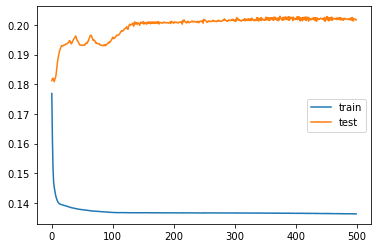

In [97]:
model = tkm.Sequential()
model.add(tkl.LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(tkl.Dense(1))
model.compile(loss='mae', optimizer='adam')

history = model.fit(train_X, train_y, epochs=500, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

#### Validation

In [76]:
#pred = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_pred = np.concatenate((pred, test_X[:, 1:]), axis=1)
inv_pred = scaler.inverse_transform(inv_pred)
inv_pred = inv_pred[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_pred))
print('Test RMSE: %.3f' % rmse)

AxisError: axis 1 is out of bounds for array of dimension 1

## Credits & Links (for dataset)

https://rpubs.com/ccong2/bike
https://towardsdatascience.com/forecast-model-tuning-with-additional-regressors-in-prophet-ffcbf1777dda